In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# Cointegration

In [2]:
#function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

import datetime as dt
import pandas_datareader.data as web

def coint_daterange(start_date,end_date, asset_list):
    stocks = asset_list
    ls_key = 'Adj Close'
    start= start_date
    end= end_date
    df=web.DataReader(stocks,'yahoo',start,end)
    cleanData = df[ls_key]
    scores, pvalues, pairs = find_cointegrated_pairs(cleanData)
    return pairs

In [4]:
import datetime as dt
import pandas_datareader.data as web

ls_key = 'Adj Close'
start= dt.datetime(2007,12,1)
end= dt.datetime(2017,12,1)

stocks = ['SPY','AAPL','ADBE','SYMC','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']

df=web.DataReader(stocks,'yahoo',start,end)
cleanData = df[ls_key]

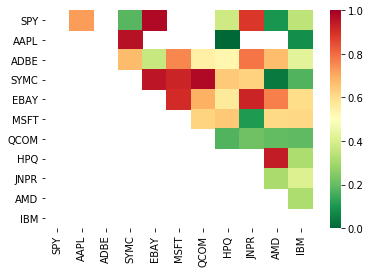

[('ADBE', 'MSFT'), ('EBAY', 'SPY')]


In [5]:
#HeatMap shows level of cointegration
#print out cointegrated pairs, i.e. p-values <.05

scores, pvalues, pairs = find_cointegrated_pairs(cleanData)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=stocks, 
                yticklabels=stocks, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

# Return

In [6]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [7]:
ratios = cleanData[pairs[0][0]] / cleanData[pairs[0][1]]
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

2519


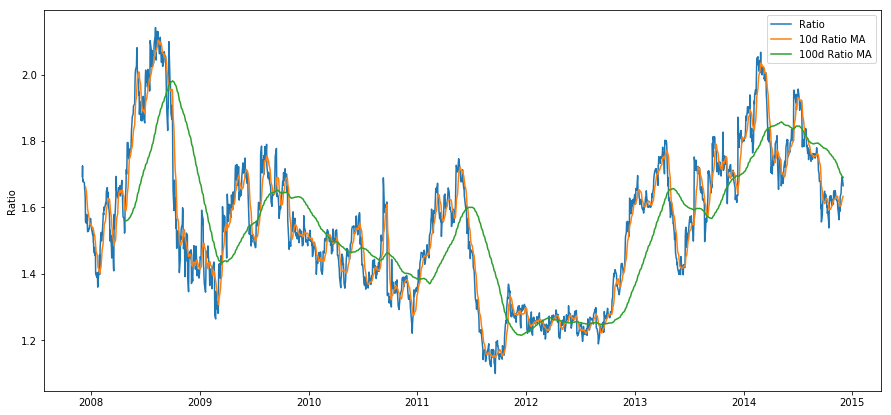

In [8]:
ratios_mavg10 = train.rolling(window=10,
                               center=False).mean()

ratios_mavg100 = train.rolling(window=100,
                               center=False).mean()

std_100 = train.rolling(window=100,
                        center=False).std()

zscore_100_10 = (ratios_mavg10 - ratios_mavg100)/std_100
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg10.index, ratios_mavg10.values)
plt.plot(ratios_mavg100.index, ratios_mavg100.values)

plt.legend(['Ratio','10d Ratio MA', '100d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

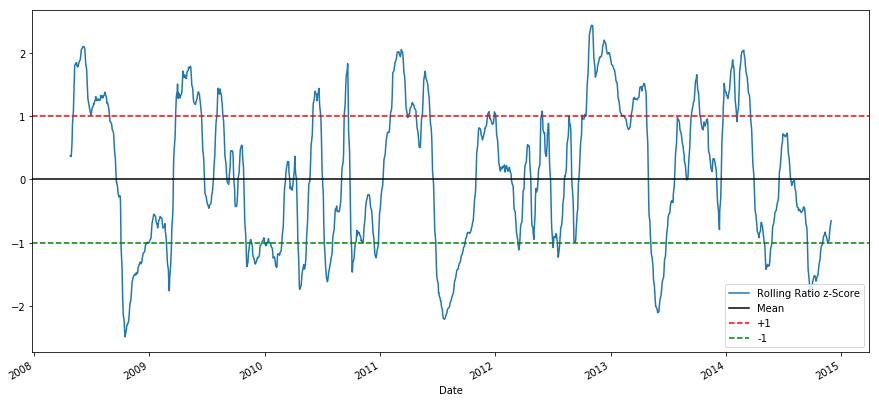

In [9]:
plt.figure(figsize=(15,7))
zscore_100_10.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

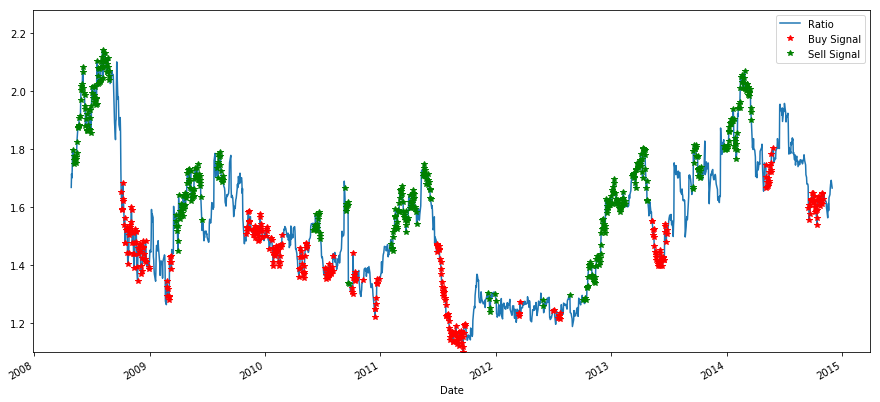

In [10]:
plt.figure(figsize=(15,7))

train[100:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_100_10>-1] = 0
sell[zscore_100_10<1] = 0
buy[100:].plot(color="r",linestyle="None", marker="*")
sell[100:].plot(color="g",linestyle="None", marker="*")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

# Trading Strategy

In [11]:
# Trade using a MA
def trade(S1, S2, window1, window2,zscore_high,zscore_low):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > zscore_high:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < zscore_low:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < .5:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            
            
    return money



In [12]:
train_retrn = np.zeros(len(pairs))

for i in range(0,len(pairs)-1):
    train_retrn[i] = trade(cleanData[pairs[i][0]].iloc[:1763],cleanData[pairs[i][1]].iloc[:1763],10,100,1,-1)
print(train_retrn)


[997.96395559   0.        ]


In [13]:
test_retrn = np.zeros(len(pairs))

for i in range(0,len(pairs)-1):
    test_retrn[i] = trade(cleanData[pairs[i][0]].iloc[1762:],cleanData[pairs[i][1]].iloc[1762:],10,100,1,-1)
print(test_retrn)

[1205.76365666    0.        ]
